# Neural Spline Flow

In [1]:
# Import required packages
import torch
import numpy as np
import normflows as nf
from torchviz import make_dot
from sklearn.datasets import make_moons
from scipy.special import erf, gamma
from matplotlib import pyplot as plt

from tqdm import tqdm

In [2]:
class Sharp(nf.distributions.Target):
    def __init__(self):
        super().__init__(prop_scale=torch.tensor(1.0), 
                         prop_shift=torch.tensor(0.0))
        self.ndims = 2
        self.int_val = 4.0
    def prob(self,x):
        return -torch.log(x[:,0])/torch.sqrt(x[:,0])
    def log_prob(self, x):
        return torch.log(torch.abs(self.prob(x)))

In [3]:
class Gauss(nf.distributions.Target):
    def __init__(self):
        super().__init__(prop_scale=torch.tensor(1.0), 
                         prop_shift=torch.tensor(0.0))
        self.ndims = 2
        self.alpha = 0.2
        self.log_const = -self.ndims *(np.log(self.alpha) + 0.5 * np.log(np.pi))
    
    def log_prob(self, x):
        return -1.0 * torch.sum((x-0.5)**2/self.alpha**2, -1) + self.log_const
    def prob(self, x):
        return torch.exp(self.log_prob(x))

In [4]:
class Camel(nf.distributions.Target):
    def __init__(self):
        super().__init__(prop_scale=torch.tensor(1.0), 
                         prop_shift=torch.tensor(0.0))
        self.ndims = 2
        self.alpha = 0.2
        self.pre = np.exp(-self.ndims *(np.log(self.alpha) + 0.5 * np.log(np.pi)))
        
    def log_prob(self, x):
        return torch.log(self.prob(x))
    def prob(self, x):
        exp1 = -1.0 * torch.sum((x-(1./8.))**2/self.alpha**2, -1)
        exp2 = -1.0 * torch.sum((x-(7./8.))**2/self.alpha**2, -1) 
        return 0.5 * self.pre * torch.exp(exp1) + 0.25 * self.pre * torch.exp(exp2) 
        

In [5]:
# Set up model
target = Gauss()
# Define flows
K = 2
torch.manual_seed(0)

latent_size = 2
hidden_units = 4
hidden_layers = 2

flows = []
#for i in range(K):
#     flows += [nf.flows.CoupledRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
#     flows += [nf.flows.LULinearPermute(latent_size)]
flows += [nf.flows.CoupledRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
flows += [nf.flows.CoupledRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, reverse_mask=True)]
# Set base distribuiton
q0 = nf.distributions.base.Uniform(2, 0.0, 1.0)
    
# Construct flow model
nfm = nf.NormalizingFlow(q0, flows, target)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
nfm = nfm.to(device)

/home/wangtao/miniconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[2.9656e-05, 3.8078e-05, 4.8643e-05,  ..., 4.8643e-05, 3.8078e-05,
         2.9656e-05],
        [3.8078e-05, 4.8892e-05, 6.2457e-05,  ..., 6.2457e-05, 4.8892e-05,
         3.8078e-05],
        [4.8643e-05, 6.2457e-05, 7.9786e-05,  ..., 7.9786e-05, 6.2457e-05,
         4.8643e-05],
        ...,
        [4.8643e-05, 6.2457e-05, 7.9786e-05,  ..., 7.9786e-05, 6.2457e-05,
         4.8643e-05],
        [3.8078e-05, 4.8892e-05, 6.2457e-05,  ..., 6.2457e-05, 4.8892e-05,
         3.8078e-05],
        [2.9656e-05, 3.8078e-05, 4.8643e-05,  ..., 4.8643e-05, 3.8078e-05,
         2.9656e-05]])
tensor([[-10.4259, -10.1759,  -9.9310,  ...,  -9.9310, -10.1759, -10.4259],
        [-10.1759,  -9.9259,  -9.6810,  ...,  -9.6810,  -9.9259, -10.1759],
        [ -9.9310,  -9.6810,  -9.4362,  ...,  -9.4362,  -9.6810,  -9.9310],
        ...,
        [ -9.9310,  -9.6810,  -9.4362,  ...,  -9.4362,  -9.6810,  -9.9310],
        [-10.1759,  -9.9259,  -9.6810,  ...,  -9.6810,  -9.9259, -10.1759],
        [-1

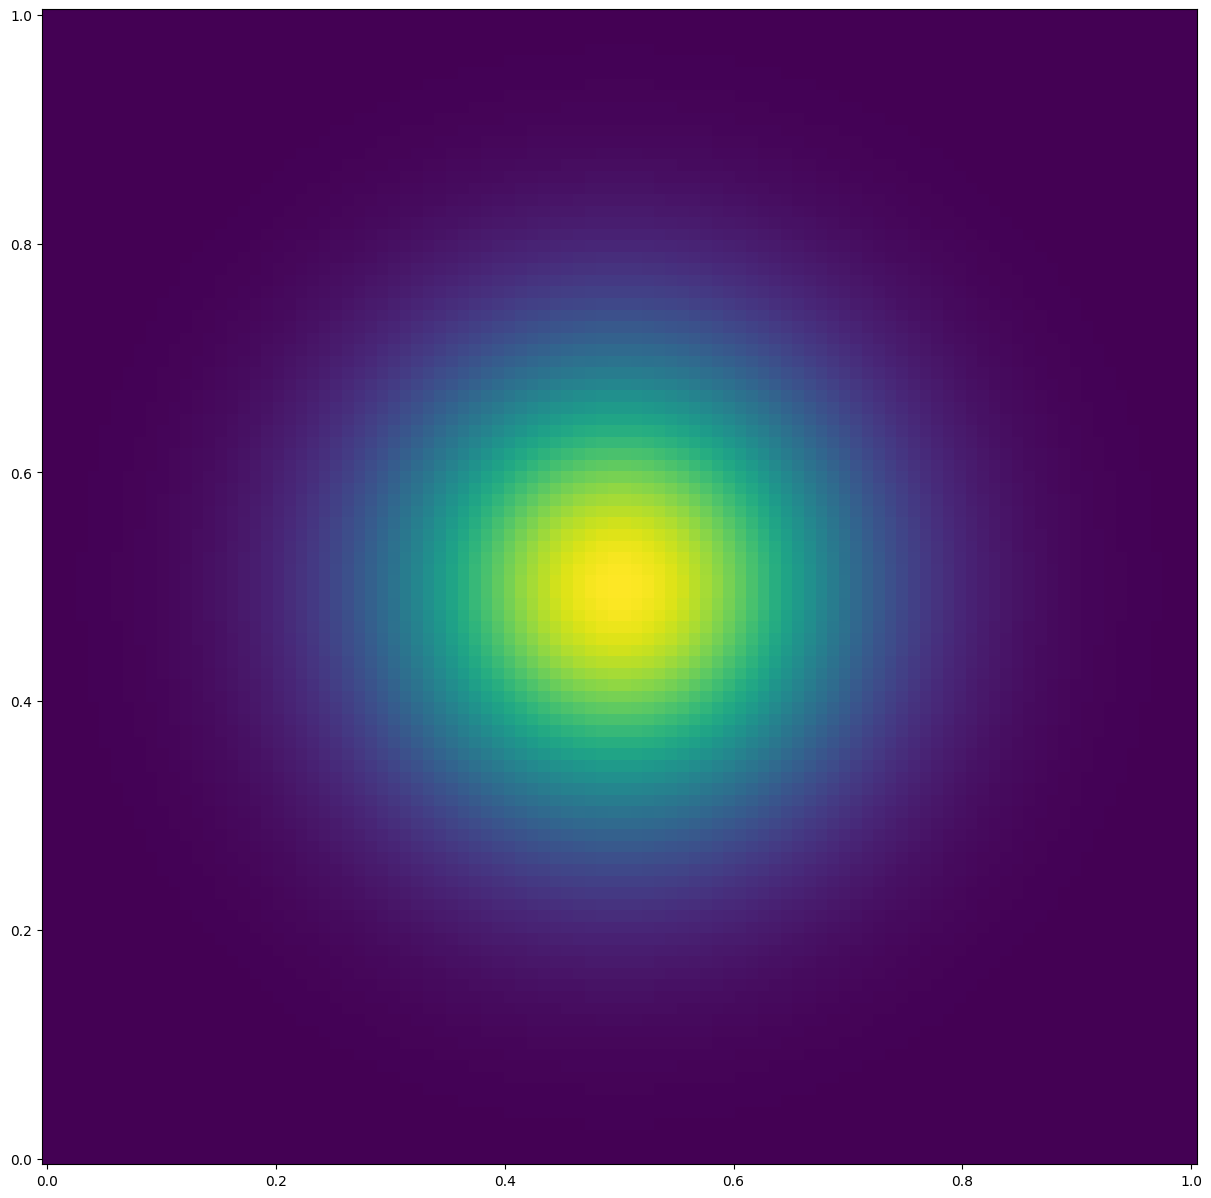

In [6]:
# Plot target distribution
# x_np, _ = make_moons(2 ** 20, noise=0.1)
# plt.figure(figsize=(15, 15))
# plt.hist2d(x_np[:, 0], x_np[:, 1], bins=200)
# plt.show()

# Plot initial flow distribution
grid_size = 100
xx, yy = torch.meshgrid(torch.linspace(0.0, 1.0, grid_size), torch.linspace(0.0, 1.0, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

nfm.eval()
log_prob = nfm.p.log_prob(zz).to('cpu').view(*xx.shape)
prob = nfm.p.prob(zz).to('cpu').view(*xx.shape)
#prob = nfm.p.prob(zz).to('cpu').view(*xx.shape)
#print(prob, log_prob)
log_q = nfm.log_prob(zz).to('cpu').view(*xx.shape)
print(prob)
#log_prob = log_prob - log_q
print(log_prob,log_q)
nfm.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.gca().set_aspect('equal', 'box')
plt.show()

 50%|███████████████████▉                    | 998/2000 [01:02<01:00, 16.46it/s]

tensor(1.0001, grad_fn=<MeanBackward0>) tensor(0.0008, grad_fn=<MeanBackward0>)
Gradient of flows.0.prqct.transform_net.final_layer.weight is 
tensor([[-0.0050],
        [-0.0009],
        [-0.0030],
        [-0.0016],
        [ 0.0036],
        [ 0.0010],
        [ 0.0022],
        [ 0.0037],
        [ 0.0024],
        [ 0.0003],
        [ 0.0023],
        [ 0.0010],
        [-0.0036],
        [-0.0007],
        [-0.0004],
        [-0.0013],
        [ 0.0003],
        [ 0.0017],
        [-0.0016],
        [ 0.0006],
        [ 0.0021],
        [ 0.0017],
        [-0.0026],
        [ 0.0035],
        [-0.0009]])
Gradient of flows.0.prqct.transform_net.final_layer.bias is 
tensor([-1.1328e-02, -1.0080e-03, -5.1309e-03, -1.5656e-03,  7.9015e-03,
         2.1595e-03,  4.6622e-03,  4.3088e-03,  5.2271e-03,  2.8199e-05,
         4.1999e-03,  4.8707e-04, -7.5248e-03, -8.9107e-04, -8.2054e-04,
        -7.0592e-04,  3.3405e-04,  2.9491e-03, -2.4276e-03,  1.8802e-03,
         2.9038e-03,  3.1172

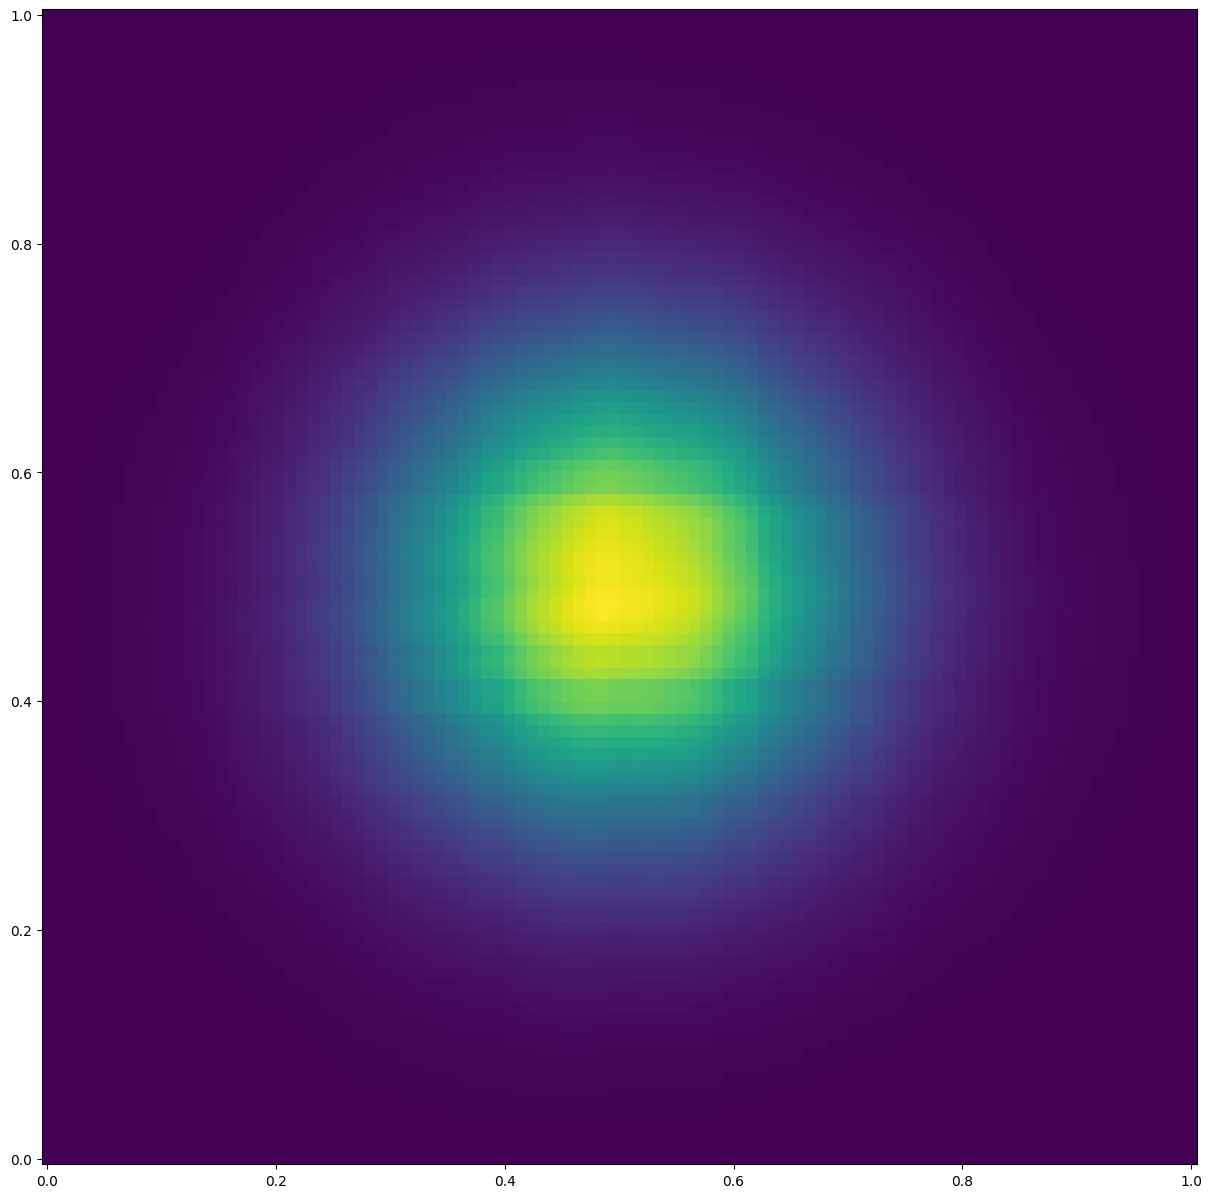

100%|██████████████████████████████████████▉| 1998/2000 [02:03<00:00, 16.39it/s]

tensor(0.9987, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<MeanBackward0>)
Gradient of flows.0.prqct.transform_net.final_layer.weight is 
tensor([[ 2.5201e-03],
        [ 9.7249e-04],
        [ 1.5222e-03],
        [-9.7498e-04],
        [-2.5722e-04],
        [-2.4238e-03],
        [ 1.1433e-03],
        [-2.5021e-03],
        [-1.0877e-03],
        [-2.0518e-05],
        [-1.2259e-03],
        [ 1.0869e-03],
        [-8.8863e-05],
        [ 2.0007e-03],
        [-1.6337e-03],
        [ 9.6918e-04],
        [ 1.4765e-05],
        [-3.4003e-04],
        [-4.6373e-04],
        [ 3.4028e-03],
        [-2.1802e-03],
        [ 6.7218e-04],
        [-2.6915e-04],
        [ 1.0032e-03],
        [-6.6290e-05]])
Gradient of flows.0.prqct.transform_net.final_layer.bias is 
tensor([ 0.0078,  0.0015,  0.0042,  0.0028, -0.0020, -0.0052, -0.0016, -0.0074,
        -0.0028,  0.0017, -0.0030, -0.0025,  0.0010,  0.0038, -0.0006,  0.0023,
         0.0004, -0.0001, -0.0021,  0.0070, -0.0038,  0.0018

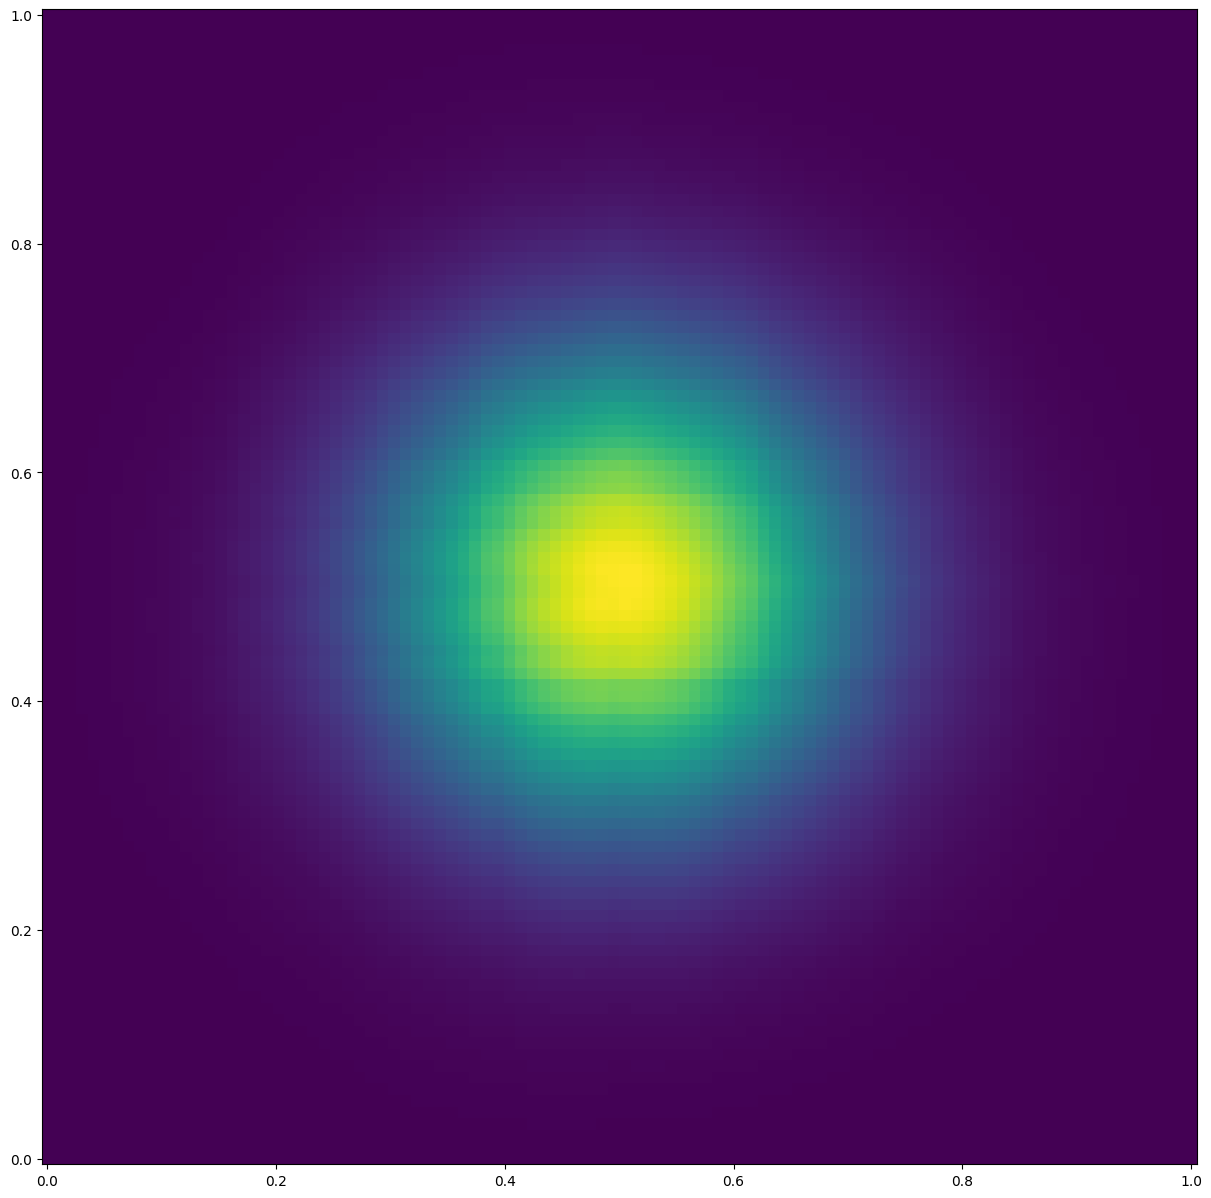

100%|███████████████████████████████████████| 2000/2000 [02:04<00:00, 16.11it/s]


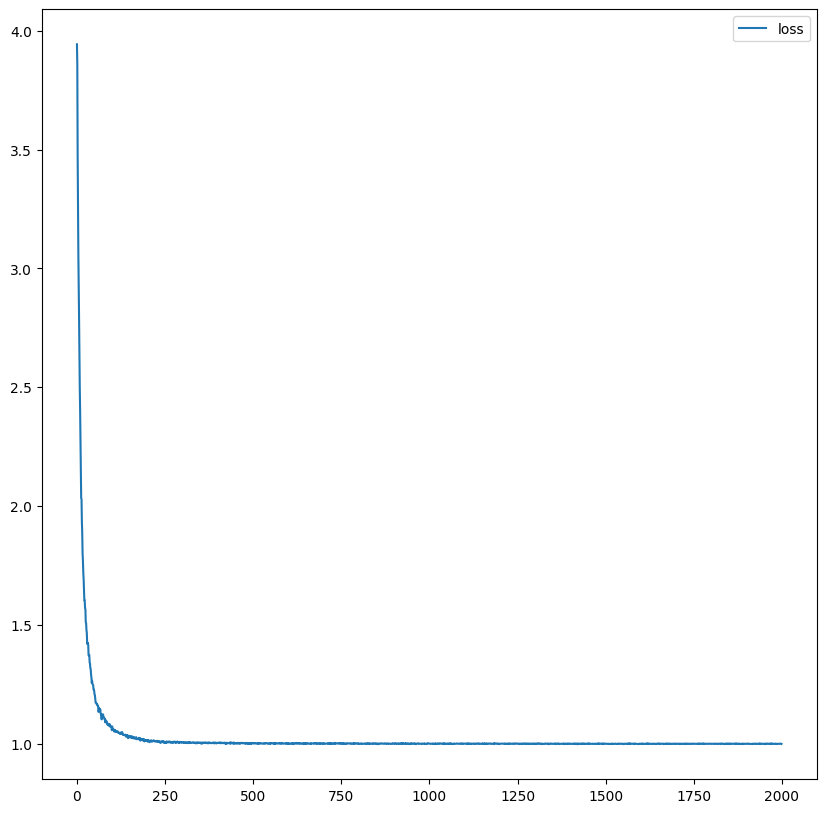

In [7]:
# Train model
max_iter = 2000
num_samples = 10000
show_iter = 1000
clip = 10.0

loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-2)#, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, max_iter)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
#     x_np, _ = make_moons(num_samples, noise=0.1)
#     x = torch.tensor(x_np).float().to(device)
    
    # Compute loss
#     if(it<max_iter/2):
#         loss = nfm.reverse_kld(num_samples)
#     else:
    loss = nfm.MCvar(num_samples)
    #loss = nfm.IS_forward_kld(num_samples)
    loss2 = nfm.IS_forward_kld(num_samples)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        if (it+1)%show_iter == 0:
            print(loss, loss2)
            # make_dot(z, params=dict(nfm.named_parameters()))
            for name, param in nfm.named_parameters():
                print(f"Gradient of {name} is \n{param.grad}")
        torch.nn.utils.clip_grad_value_(nfm.parameters(), clip)
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        nfm.eval()
        log_prob = nfm.log_prob(zz)
        nfm.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(15, 15))
        plt.pcolormesh(xx, yy, prob.data.numpy())
        plt.gca().set_aspect('equal', 'box')
        plt.show()
    scheduler.step()


# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

tensor([[-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        ...,
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.]]) tensor([[-2.3842e-07, -2.3842e-07, -2.9802e-07,  ..., -3.5763e-07,
         -1.1921e-07, -2.3842e-07],
        [-2.3842e-07, -2.3842e-07, -2.9802e-07,  ..., -3.5763e-07,
         -1.1921e-07, -2.3842e-07],
        [-2.9802e-07, -2.9802e-07, -3.5763e-07,  ..., -4.1723e-07,
         -1.7881e-07, -2.9802e-07],
        ...,
        [-3.5763e-07, -3.5763e-07, -4.1723e-07,  ..., -4.7684e-07,
         -2.3842e-07, -3.5763e-07],
        [-1.1921e-07, -1.1921e-07, -1.7881e-07,  ..., -2.3842e-07,
          0.0000e+00, -1.1921e-07],
        [-2.3842e-07, -2.3842e-07, -2.9802e-07,  ..., -3.5763e-07,
         -1.1921e-07, -2.3842e-07]], grad_fn=<ViewBackward0>)


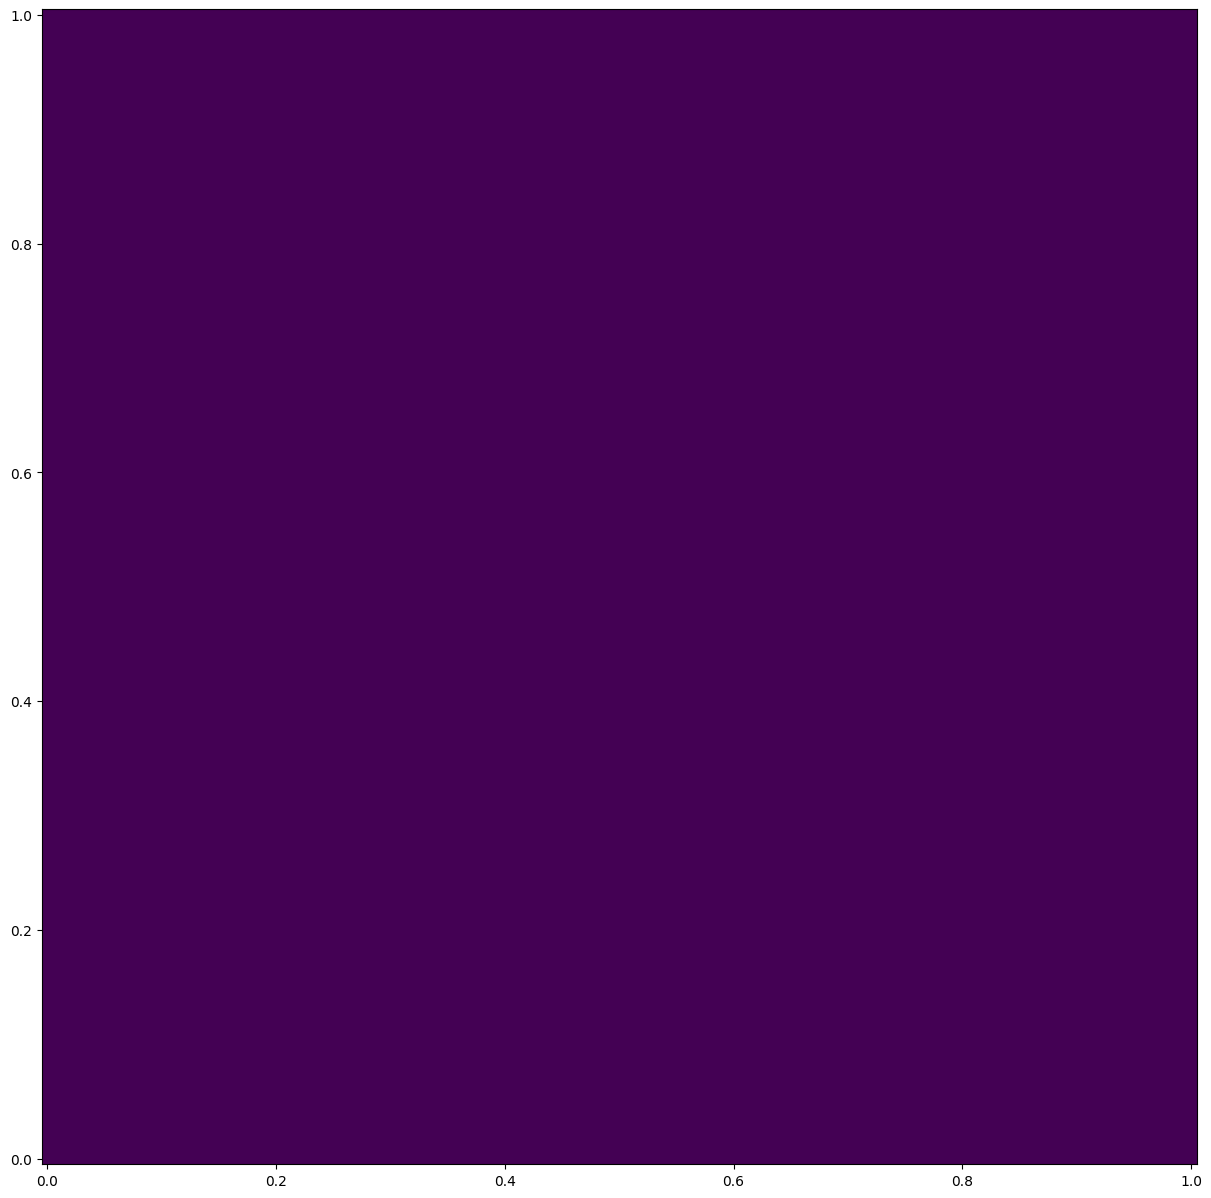

In [8]:
# Plot target distribution
# x_np, _ = make_moons(2 ** 20, noise=0.1)
# plt.figure(figsize=(15, 15))
# plt.hist2d(x_np[:, 0], x_np[:, 1], bins=200)
# plt.show()

# Plot initial flow distribution
grid_size = 100
xx, yy = torch.meshgrid(torch.linspace(0.0, 1.0, grid_size), torch.linspace(0.0, 1.0, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

nfm.eval()
#log_prob = nfm.p.log_prob(zz).to('cpu').view(*xx.shape)
#prob = nfm.p.prob(zz).to('cpu').view(*xx.shape)
#prob = nfm.p.prob(zz).to('cpu').view(*xx.shape)
#print(prob, log_prob)
log_prob = nfm.q0.log_prob(zz).to('cpu').view(*xx.shape)
#print(prob)
#log_prob = log_prob - log_q
print(log_prob,log_q)
nfm.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.gca().set_aspect('equal', 'box')
plt.show()

Estimating integral from trained network


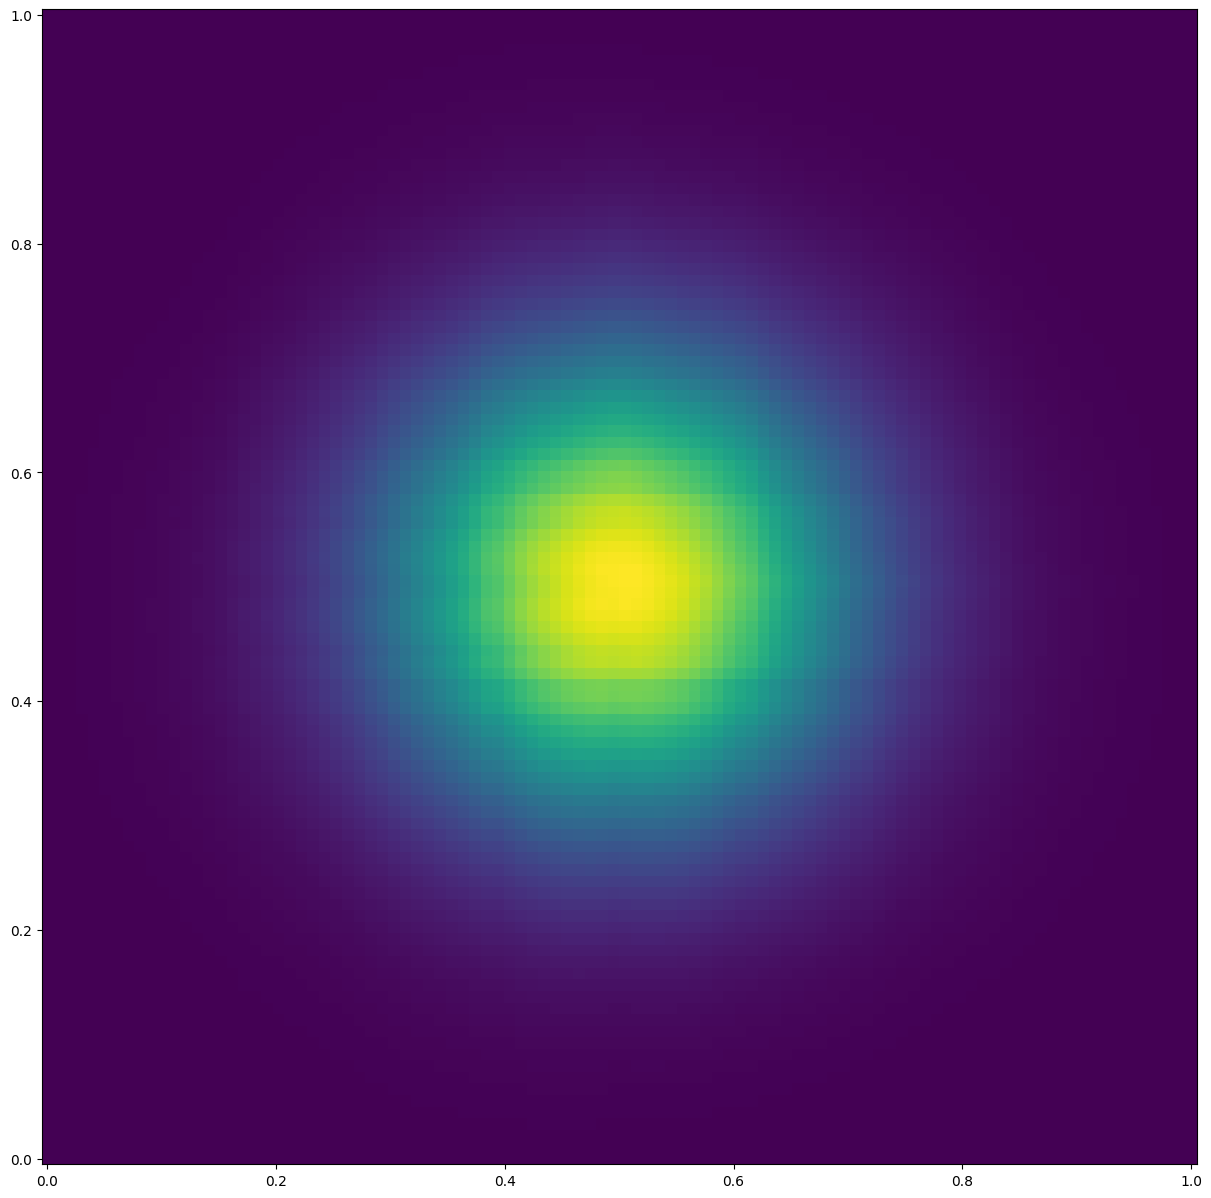

torch.Size([100000, 2]) 0.999187667965889 7.364236577392297e-05 0.9991862615750545


In [9]:
# Plot learned distribution
nfm.eval()
samples, logdetJ = nfm.sample(100000)
mean, variance = nfm.integrate_block(100000, 100)
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
nfm.train()

prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.gca().set_aspect('equal', 'box')
plt.show()
alpha = 0.2
ndims = 2
target_val = erf(1/(2.*alpha))**ndims
print(samples.shape, mean, variance, target_val)

[[0.5118067  0.76930815]
 [0.50334066 0.5030088 ]
 [0.2716825  0.79570556]
 ...
 [0.5475671  0.534948  ]
 [0.40792316 0.3636576 ]
 [0.5047229  0.490992  ]]


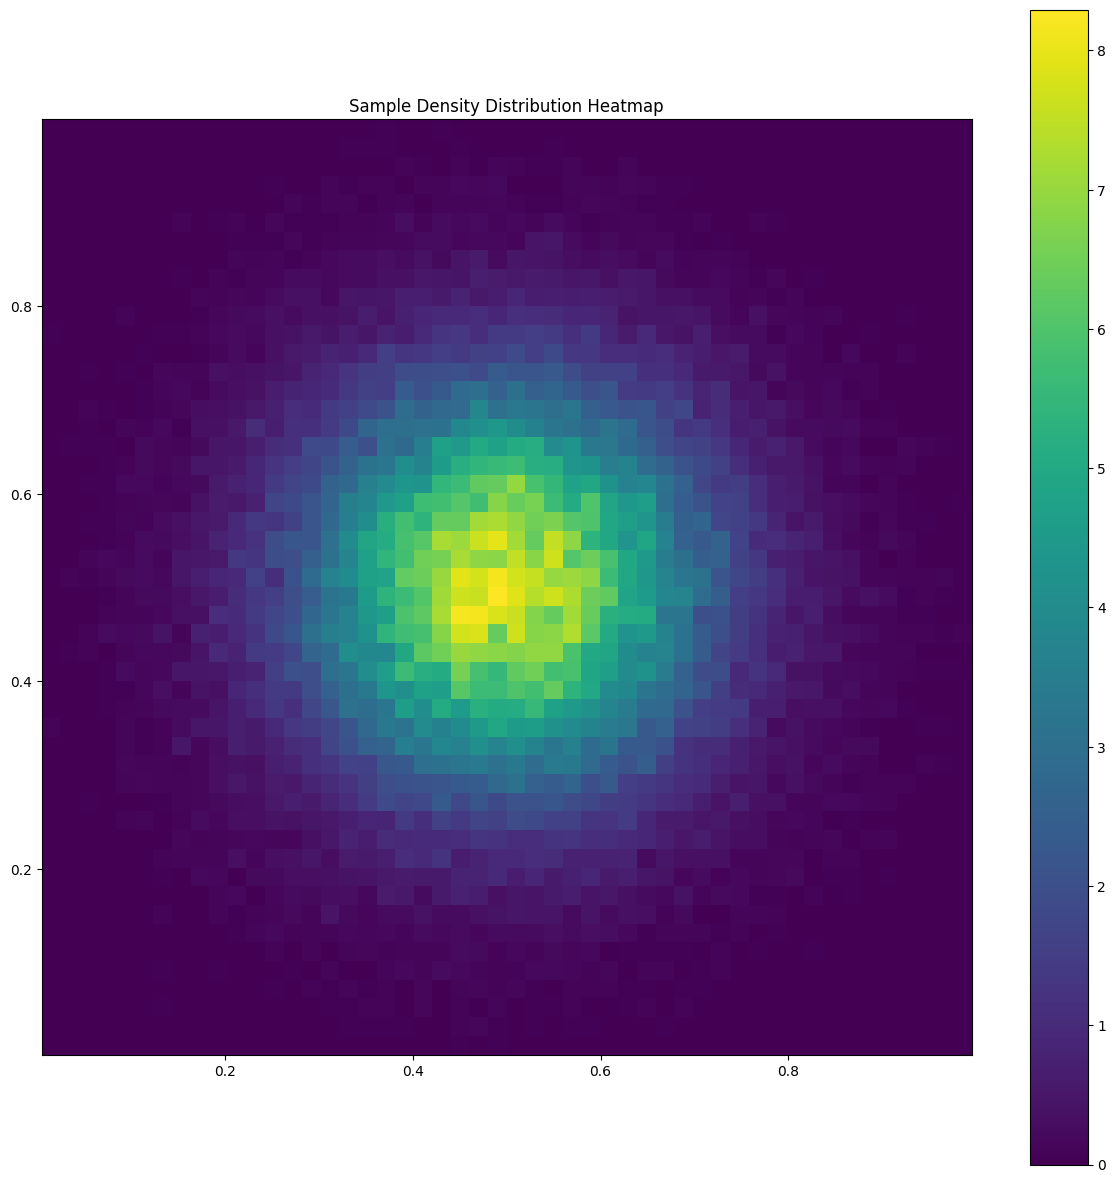

In [10]:
samples_np = samples.detach().numpy()
print(samples_np)
# Create a 2D histogram of the samples
hist, xedges, yedges = np.histogram2d(samples_np[:,0], samples_np[:,1], bins=50, density=True)

# Generate the x and y coordinates for the centers of the bins
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
X, Y = np.meshgrid(xcenters, ycenters)

# Plot the heatmap
plt.figure(figsize=(15, 15))
plt.pcolormesh(X, Y, hist, shading='auto')
plt.colorbar() # Show color scale
plt.gca().set_aspect('equal', 'box') # Keep aspect ratio square
plt.title('Sample Density Distribution Heatmap')
plt.show()